# 3. Quantization

This notebook demonstrates how to quantize a model to INT8 using `torch.quantization`. Quantization, and especially INT8 quantization, aims to transform a 32-bits floating-point model into a more efficient 8-bits integer representation, leading up to 4x smaller model size and faster inference times due to integer arithmetic.

This is achieved by replacing the floating-point operations in the model with their integer counterparts. This requires a calibration step to determine the scale ($S$) and zero-point ($Z$) for each quantized tensor. The relationship between the real-world floating-point value ($r$) and its quantized integer representation ($q$) is given by:

$q = \text{round}(r / S) + Z$

Conversely, the dequantized value ($r_{\text{approx}}$) can be obtained by:

$r_{\text{approx}} = S \cdot (q - Z)$

The calibration process involves running inference on a representative dataset (the calibration dataset) to observe the range of activation values and determine appropriate $S$ and $Z$ values for each layer's weights and activations to minimize the loss of accuracy due to quantization.

Quantization is applied to both the weights and activations of the model. The weights are quantized to INT8, while the activations can be quantized to either INT8 or UINT8, depending on the use case. The choice of quantization type (symmetric vs. asymmetric) also affects how $S$ and $Z$ are calculated.

There are two main approaches to quantizing a model:

* **Post-Training Quantization (PTQ):** This is the simpler approach where a pre-trained FP32 model is quantized without any retraining. It involves:
    * Calibrating the model by feeding it a small, representative dataset (calibration data) to collect statistics (e.g., min/max ranges) of the weights and activations.
    *   These statistics are then used to calculate the quantization parameters ($S$ and $Z$) for each layer.
PTQ is fast and easy to implement but might lead to a more significant accuracy drop, especially for models sensitive to quantization.

* **Quantization-Aware Training (QAT):** QAT simulates the quantization effects (noise and clamping) during the training or fine-tuning process. It inserts "fake quantization" modules into the model architecture. These modules mimic the quantization and dequantization steps during the forward pass, while the backward pass uses straight-through estimators (STE) to allow gradients to flow.
The model learns to become robust to the quantization noise, often resulting in better accuracy compared to PTQ, but it requires access to the training pipeline and more computational resources.

The choice of $S$ and $Z$ is crucial for minimizing the quantization error. Common methods include:

* **Min-Max:** The simplest method. $S$ and $Z$ are determined by the minimum ($r_{\text{min}}$) and maximum ($r_{\text{max}}$) values observed in the tensor during calibration. Depending on how 0.0f maps to integers, the formulas are:
    * For asymmetric quantization (where 0.0f might not map to an integer 0):
        $S = (r_{\text{max}} - r_{\text{min}}) / (q_{\text{max}} - q_{\text{min}})$
        $Z = q_{\text{min}} - \text{round}(r_{\text{min}} / S)$
        (where $q_{\text{min}}$ and $q_{\text{max}}$ are the min/max values of the target integer range, e.g., 0 and 255 for uint8, or -128 and 127 for int8).
    * For symmetric quantization (where 0.0f maps to integer 0, so $Z=0$ for signed types or $Z$ is fixed for unsigned types):
        $S = \max(|r_{\text{min}}|, |r_{\text{max}}|) / \text{range\_limit}$
        (e.g., `range_limit` is 127 for int8).
This method is sensitive to outliers, as a single extreme value can significantly skew the range and thus the scale.

* **Percentile:** Instead of using the absolute min/max, this method uses percentile values (e.g., 1st and 99th percentile, or 0.1th and 99.9th percentile) of the observed data range to determine $r_{\text{min}}$ and $r_{\text{max}}$. This helps to mitigate the impact of extreme outliers.

* **Histogram:** This method builds a histogram of the observed values and uses the histogram to determine the quantization parameters. It can be more robust against outliers than min-max, as it considers the distribution of values rather than just the extremes.

* **Entropy (or KL-Divergence):** This method aims to find quantization parameters that minimize the information loss, often measured by the Kullback-Leibler (KL) divergence between the distribution of the original FP32 values and the dequantized INT8 values. It involves iterating through different clipping thresholds (which define the effective $r_{\text{min}}$ and $r_{\text{max}}$) and selecting the one that minimizes the KL divergence. This often provides a better trade-off between range coverage and quantization precision, especially when outliers are present.

In this notebook, we will apply PTQ and QAT to a MobileNetV2 model adapted for the CIFAR-10 dataset, using the `torch.quantization` default modules and methods (histogram for activations, min-max for weights). We will compare the accuracy of the quantized model with the original FP32 model and observe the impact of quantization on model size and inference speed on CPU.

# Setup

In [1]:
from typing import Any

import torch

from matplotlib import pyplot as plt

from nnopt.model.eval import eval_model
from nnopt.model.quant import post_training_quantization, quantization_aware_training
from nnopt.model.const import DEVICE, DTYPE

from nnopt.recipes.mobilenetv2_cifar10 import get_mobilenetv2_cifar10_model, get_cifar10_datasets, save_quantized_mobilenetv2_cifar10_model, convert_mobilenetv2_cifar10_to_quantized, get_quantized_mobilenetv2_cifar10_model

2025-06-11 16:01:40,246 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Using device: cuda, dtype: torch.bfloat16


In [2]:
# CIFAR-10 dataset
cifar10_train_dataset, cifar10_val_dataset, cifar10_test_dataset = get_cifar10_datasets()

2025-06-11 16:01:40,255 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading existing training and validation datasets...
2025-06-11 16:01:41,821 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading existing test dataset...


In [3]:
def ptq_mobilenetv2_cifar10(
    version: str = "mobilenetv2_cifar10/baseline"
) -> tuple[torch.nn.Module, dict[str, Any], dict[str, Any]]:
    """
    Post-training quantization of MobileNetV2 on CIFAR-10.
    """
    # Load the baseline model
    mobilenetv2_cifar10_quant, mobilenetv2_cifar10_metadata = get_mobilenetv2_cifar10_model(version=version)

    # Post-training quantization
    mobilenetv2_cifar10_ptq_int8 = post_training_quantization(
        model=convert_mobilenetv2_cifar10_to_quantized(mobilenetv2_cifar10_quant),
        val_dataset=cifar10_val_dataset,
        num_calibration_batches=100,
        batch_size=32,
    )

    # Evaluate the quantized model
    val_metrics = eval_model(
        model=mobilenetv2_cifar10_ptq_int8,
        test_dataset=cifar10_val_dataset,
        device="cpu",
        use_amp=False,
        dtype=torch.float32,
    )
    test_metrics = eval_model(
        model=mobilenetv2_cifar10_ptq_int8,
        test_dataset=cifar10_test_dataset,
        device="cpu",
        use_amp=False,
        dtype=torch.float32,
    )

    mobilenetv2_cifar10_val_accuracy_quantized = val_metrics["accuracy"]
    mobilenetv2_cifar10_test_accuracy_quantized = test_metrics["accuracy"]

    print(f"Validation accuracy of MobileNetV2 on CIFAR-10 (quantized): {mobilenetv2_cifar10_val_accuracy_quantized:.2f}")
    print(f"Test accuracy of MobileNetV2 on CIFAR-10 (quantized): {mobilenetv2_cifar10_test_accuracy_quantized:.2f}")

    # Save the quantized model
    save_quantized_mobilenetv2_cifar10_model(
        model=mobilenetv2_cifar10_ptq_int8,
        version=f"mobilenetv2_cifar10/int8/ptq_{version}",
        metrics_values=val_metrics,
        unstruct_sparse_config=mobilenetv2_cifar10_metadata.get("unstruct_sparse_config", None),
    )

    return mobilenetv2_cifar10_ptq_int8, val_metrics, test_metrics

In [4]:
def qat_mobilenetv2_cifar10(
    version: str = "mobilenetv2_cifar10/baseline",
) -> tuple[torch.nn.Module, dict[str, Any], dict[str, Any]]:
    """
    Quantization-aware training of MobileNetV2 on CIFAR-10.
    """
    # Load the baseline model
    mobilenetv2_cifar10_quant, mobilenetv2_cifar10_metadata = get_mobilenetv2_cifar10_model(version=version)

    # Quantization-aware training
    mobilenetv2_cifar10_qat_int8 = quantization_aware_training(
        model=convert_mobilenetv2_cifar10_to_quantized(mobilenetv2_cifar10_quant),
        train_dataset=cifar10_train_dataset,
        val_dataset=cifar10_val_dataset,
        epochs=1,
        batch_size=64,
        training_device=DEVICE
    )

    # Evaluate the quantized model
    val_metrics = eval_model(
        model=mobilenetv2_cifar10_qat_int8,
        test_dataset=cifar10_val_dataset,
        device="cpu",
        use_amp=False,
        dtype=torch.float32,
    )
    test_metrics = eval_model(
        model=mobilenetv2_cifar10_qat_int8,
        test_dataset=cifar10_test_dataset,
        device="cpu",
        use_amp=False,
        dtype=torch.float32,
    )

    mobilenetv2_cifar10_val_accuracy_quantized = val_metrics["accuracy"]
    mobilenetv2_cifar10_test_accuracy_quantized = test_metrics["accuracy"]

    print(f"Validation accuracy of MobileNetV2 on CIFAR-10 (quantized): {mobilenetv2_cifar10_val_accuracy_quantized:.2f}")
    print(f"Test accuracy of MobileNetV2 on CIFAR-10 (quantized): {mobilenetv2_cifar10_test_accuracy_quantized:.2f}")

    # Save the quantized model
    save_quantized_mobilenetv2_cifar10_model(
        model=mobilenetv2_cifar10_qat_int8,
        version=f"mobilenetv2_cifar10/int8/qat_{version}",
        metrics_values=val_metrics,
        unstruct_sparse_config=mobilenetv2_cifar10_metadata.get("unstruct_sparse_config", None),
    )
    return mobilenetv2_cifar10_qat_int8, val_metrics, test_metrics

# Post-Training Quantization (PTQ)

## Baseline Model

In [15]:
mobilenetv2_cifar10_ptq_int8, mobilenetv2_cifar10_ptq_int8_val_metrics, mobilenetv2_cifar10_ptq_int8_test_metrics = ptq_mobilenetv2_cifar10(
    version="mobilenetv2_cifar10/fp32/baseline",
)

2025-06-11 15:02:30,841 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 (architecture and weights) from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 15:02:30,904 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded model from /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/baseline/model.pt
2025-06-11 15:02:30,905 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.8988, 'avg_loss': 0.2952394811630249, 'samples_per_second': 8822.506935259542, 'avg_time_per_batch': 0.007173827088484393, 'avg_time_per_sample': 0.00011334646799805342, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_params': 10, 'bn_param_params': 34112, 'other_float_params': 0, 'total_params': 2236682, 'approx_memory_mb_for_params': 8.532264709472656}}, 'test_metrics': {'accuracy': 0.9004, 'avg_loss': 0.29234390649795533, 'sa

Evaluation Complete: Avg Loss: 11.4619, Accuracy: 0.1038
Throughput: 1088.05 samples/sec | Avg Batch Time: 29.27 ms | Avg Sample Time: 0.92 ms
System Stats: CPU Usage: 16.80% | RAM Usage: 7.8/30.9GB (29.2%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 15.02it/s]
2025-06-11 15:04:00,837 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:04<00:00, 31.62it/s, acc=0.1038, cpu=51.4%, loss=10.0039, ram=8.0/30.9GB (29.9%), samples/s=747.6] 
2025-06-11 15:04:05,823 - nnopt.model.eval - INFO - Starting evaluation on device: cpu, dtype: torch.float32, batch size: 32
2025-06-11 15:04:05,825 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 11.4619, Accuracy: 0.1038
Throughput: 1117.97 samples/sec | Avg Batch Time: 28.49 ms | Avg Sample Time: 0.89 ms
System Stats: CPU Usage: 16.00% | RAM Usage: 7.8/30.9GB (29.2%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 14.54it/s]
2025-06-11 15:04:06,266 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 313/313 [00:09<00:00, 31.67it/s, acc=0.0991, cpu=48.5%, loss=12.4768, ram=8.1/30.9GB (30.0%), samples/s=878.3] 
2025-06-11 15:04:16,192 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/int8/ptq_mobilenetv2_cifar10/fp32/baseline/metadata.json
2025-06-11 15:04:16,193 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/int8/ptq_mobilenetv2_cifar10/fp32/baseline/model.pt


Evaluation Complete: Avg Loss: 11.4285, Accuracy: 0.0991
Throughput: 1103.24 samples/sec | Avg Batch Time: 28.96 ms | Avg Sample Time: 0.91 ms
System Stats: CPU Usage: 15.00% | RAM Usage: 7.8/30.9GB (29.2%)
Validation accuracy of MobileNetV2 on CIFAR-10 (quantized): 0.10
Test accuracy of MobileNetV2 on CIFAR-10 (quantized): 0.10


# Quantization-Aware Training (QAT)

## Baseline Model

In [5]:
mobilenetv2_cifar10_qat_int8, mobilenetv2_cifar10_qat_int8_val_metrics, mobilenetv2_cifar10_qat_int8_test_metrics = qat_mobilenetv2_cifar10(
    version="mobilenetv2_cifar10/fp32/baseline"
)

2025-06-11 16:01:46,225 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 (architecture and weights) from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 16:01:46,427 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded model from /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/baseline/model.pt
2025-06-11 16:01:46,428 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.8988, 'avg_loss': 0.2952394811630249, 'samples_per_second': 8822.506935259542, 'avg_time_per_batch': 0.007173827088484393, 'avg_time_per_sample': 0.00011334646799805342, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_params': 10, 'bn_param_params': 34112, 'other_float_params': 0, 'total_params': 2236682, 'approx_memory_mb_for_params': 8.532264709472656}}, 'test_metrics': {'accuracy': 0.9004, 'avg_loss': 0.29234390649795533, 'sa

Epoch 1/1, Train Loss: 1.0182, Train Acc: 0.6463, Train Throughput: 634.00 samples/s | Val Loss: 0.5001, Val Acc: 0.8264, Val Throughput: 1431.53 samples/s | CPU Usage: 12.10% | RAM Usage: 7.9/30.9GB (29.9%) | GPU 0 Util: 54.00% | GPU 0 Mem: 11.0/24.0GB (45.7%)


[Warmup]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]
2025-06-11 16:03:08,512 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:26<00:00,  3.00it/s, acc=0.8258, cpu=4.0%, loss=0.7410, ram=8.2/30.9GB (31.2%), samples/s=273.8]
2025-06-11 16:03:34,855 - nnopt.model.quant - INFO - Quantization-aware training metrics: {'accuracy': 0.8258, 'avg_loss': 0.5212614751815796, 'samples_per_second': 193.37058471779434, 'avg_time_per_batch': 0.3273048966205156, 'avg_time_per_sample': 0.005171417366604146, 'params_stats': {'int_weight_params': 2202560, 'float_weight_params': 0, 'float_bias_params': 17066, 'bn_param_params': 0, 'other_float_params': 0, 'total_params': 2219626, 'approx_memory_mb_for_params': 2.1656265258789062}}
2025-06-11 16:03:34,855 - nnopt.model.eval - INFO - Starting evaluation on device: cpu, dtype: torch.float32, batch size: 32
2025-06-11 16:03:34,857 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.5213, Accuracy: 0.8258
Throughput: 193.37 samples/sec | Avg Batch Time: 327.30 ms | Avg Sample Time: 5.17 ms
System Stats: CPU Usage: 10.80% | RAM Usage: 7.9/30.9GB (30.3%)


[Warmup]: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
2025-06-11 16:03:35,965 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]:   5%|▌         | 8/157 [00:01<00:29,  4.98it/s, acc=0.8359, cpu=4.1%, loss=0.3849, ram=8.1/30.9GB (31.9%), samples/s=200.0]


KeyboardInterrupt: 

# 

In [6]:
get_quantized_mobilenetv2_cifar10_model(
    version="mobilenetv2_cifar10/int8/ptq_mobilenetv2_cifar10/fp32/baseline",
    device="cpu"
)

2025-06-11 15:58:15,277 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading quantized MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/int8/ptq_mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 15:58:15,278 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/int8/ptq_mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 15:58:15,278 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading base MobileNetV2 model, quantized: True


!!!!!!!!!!!!!!!!!!
/home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/int8/ptq_mobilenetv2_cifar10/fp32/baseline/model.pt
!!!!!!!!!!!!!!!!!!


TypeError: Expected state_dict to be dict-like, got <class 'torchvision.models.quantization.mobilenetv2.QuantizableMobileNetV2'>.

# Analysis

In [ ]:
# Load baseline FP32 model and its metadata
fp32_baseline_model, fp32_baseline_metadata = get_mobilenetv2_cifar10_model(version="mobilenetv2_cifar10/fp32/baseline")

# Evaluate the baseline model on CPU
print("Evaluating FP32 Baseline Model on CPU...")
fp32_baseline_val_metrics_cpu = eval_model(
    model=fp32_baseline_model,
    test_dataset=cifar10_val_dataset,
    device="cpu",
    use_amp=False,
    dtype=torch.float32,
    batch_size=32 # Using a consistent batch size for eval
)
fp32_baseline_test_metrics_cpu = eval_model(
    model=fp32_baseline_model,
    test_dataset=cifar10_test_dataset,
    device="cpu",
    use_amp=False,
    dtype=torch.float32,
    batch_size=32 # Using a consistent batch size for eval
)


2025-06-11 15:11:30,450 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 (architecture and weights) from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 15:11:30,530 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded model from /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/baseline/model.pt
2025-06-11 15:11:30,531 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.8988, 'avg_loss': 0.2952394811630249, 'samples_per_second': 8822.506935259542, 'avg_time_per_batch': 0.007173827088484393, 'avg_time_per_sample': 0.00011334646799805342, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_params': 10, 'bn_param_params': 34112, 'other_float_params': 0, 'total_params': 2236682, 'approx_memory_mb_for_params': 8.532264709472656}}, 'test_metrics': {'accuracy': 0.9004, 'avg_loss': 0.29234390649795533, 'sa

Evaluating FP32 Baseline Model on CPU...


[Warmup]: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
2025-06-11 15:11:33,403 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [01:18<00:00,  1.99it/s, acc=0.8970, cpu=39.3%, loss=0.3332, ram=8.2/30.9GB (32.6%), samples/s=93.9]
2025-06-11 15:12:52,230 - nnopt.model.eval - INFO - Starting evaluation on device: cpu, dtype: torch.float32, batch size: 32
2025-06-11 15:12:52,233 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.2994, Accuracy: 0.8970
Throughput: 63.93 samples/sec | Avg Batch Time: 498.19 ms | Avg Sample Time: 15.64 ms
System Stats: CPU Usage: 13.70% | RAM Usage: 8.0/30.9GB (31.9%)


[Warmup]: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]
2025-06-11 15:12:55,157 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 313/313 [02:52<00:00,  1.82it/s, acc=0.8979, cpu=34.1%, loss=0.0928, ram=8.0/30.9GB (31.9%), samples/s=87.0]

Evaluation Complete: Avg Loss: 0.2946, Accuracy: 0.8979
Throughput: 58.39 samples/sec | Avg Batch Time: 547.20 ms | Avg Sample Time: 17.13 ms
System Stats: CPU Usage: 15.90% | RAM Usage: 7.8/30.9GB (31.2%)


In [6]:
get_quantized_mobilenetv2_cifar10_model(
    version="mobilenetv2_cifar10/int8/ptq_mobilenetv2_cifar10/fp32/baseline",
    device="cpu"
)

2025-06-11 15:41:01,437 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading quantized MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/int8/ptq_mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 15:41:01,438 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/int8/ptq_mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 15:41:01,438 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading base MobileNetV2 model, quantized: True
/home/pbeuran/repos/nnopt/.venv/lib/python3.12/site-packages/torch/ao/quantization/utils.py:408: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torchvision.models.quantization.mobilenetv2.QuantizableMobileNetV2 was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torchvision.models.quantization.mobilenetv2.QuantizableMobileNetV2])` or the `torch.serialization.safe_globals([torchvision.models.quantization.mobilenetv2.QuantizableMobileNetV2])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [22]:
print(f"FP32 Baseline Validation Accuracy (CPU): {fp32_baseline_val_metrics_cpu['accuracy']:.3f}")
print(f"FP32 Baseline Test Accuracy (CPU): {fp32_baseline_test_metrics_cpu['accuracy']:.3f}")
print(f"FP32 Baseline Validation Time/Sample (CPU): {fp32_baseline_val_metrics_cpu['avg_time_per_sample']:.6f}s")
print(f"FP32 Baseline Test Time/Sample (CPU): {fp32_baseline_test_metrics_cpu['avg_time_per_sample']:.6f}s")
print("-" * 30)

# Print metrics for already evaluated quantized models for completeness
print("PTQ INT8 (Baseline) Test Accuracy (CPU): {:.3f}, Test Time/Sample (CPU): {:.6f}s".format(
    mobilenetv2_cifar10_ptq_int8_test_metrics['accuracy'],
    mobilenetv2_cifar10_ptq_int8_test_metrics['avg_time_per_sample']
))
print("QAT INT8 (Baseline) Test Accuracy (CPU): {:.3f}, Test Time/Sample (CPU): {:.6f}s".format(
    mobilenetv2_cifar10_qat_int8_test_metrics['accuracy'],
    mobilenetv2_cifar10_qat_int8_test_metrics['avg_time_per_sample'],
))

FP32 Baseline Validation Accuracy (CPU): 0.897
FP32 Baseline Test Accuracy (CPU): 0.898
FP32 Baseline Validation Time/Sample (CPU): 0.015643s
FP32 Baseline Test Time/Sample (CPU): 0.017127s
------------------------------
PTQ INT8 (Baseline) Test Accuracy (CPU): 0.099, Test Time/Sample (CPU): 0.000906s
QAT INT8 (Baseline) Test Accuracy (CPU): 0.875, Test Time/Sample (CPU): 0.001470s


In [27]:
import numpy as np
import matplotlib.pyplot as plt # Ensure matplotlib is imported

# Data for plotting
model_names = [
    "FP32 Baseline",
    "PTQ INT8 (Baseline)",
    "QAT INT8 (Baseline)"
]

val_accuracies = [
    fp32_baseline_val_metrics_cpu['accuracy'],
    mobilenetv2_cifar10_ptq_int8_val_metrics['accuracy'],
    mobilenetv2_cifar10_qat_int8_val_metrics['accuracy'],
]

test_accuracies = [
    fp32_baseline_test_metrics_cpu['accuracy'],
    mobilenetv2_cifar10_ptq_int8_test_metrics['accuracy'],
    mobilenetv2_cifar10_qat_int8_test_metrics['accuracy'],
]

cpu_time_per_sample_val = [
    fp32_baseline_val_metrics_cpu['avg_time_per_sample'],
    mobilenetv2_cifar10_ptq_int8_val_metrics['avg_time_per_sample'],
    mobilenetv2_cifar10_qat_int8_val_metrics['avg_time_per_sample'],
]

cpu_time_per_sample_test = [
    fp32_baseline_test_metrics_cpu['avg_time_per_sample'],
    mobilenetv2_cifar10_ptq_int8_test_metrics['avg_time_per_sample'],
    mobilenetv2_cifar10_qat_int8_test_metrics['avg_time_per_sample'],
]

total_params_mb_fn = lambda metrics: metrics['params_stats']['total_params'] * metrics["params_stats"]["approx_memory_mb_for_params"]
total_params_mb_val = [
    total_params_mb_fn(fp32_baseline_val_metrics_cpu),
    total_params_mb_fn(mobilenetv2_cifar10_ptq_int8_val_metrics),
    total_params_mb_fn(mobilenetv2_cifar10_qat_int8_val_metrics)
]
total_params_mb_test = [
    total_params_mb_fn(fp32_baseline_test_metrics_cpu),
    total_params_mb_fn(mobilenetv2_cifar10_ptq_int8_test_metrics),
    total_params_mb_fn(mobilenetv2_cifar10_qat_int8_test_metrics)
]

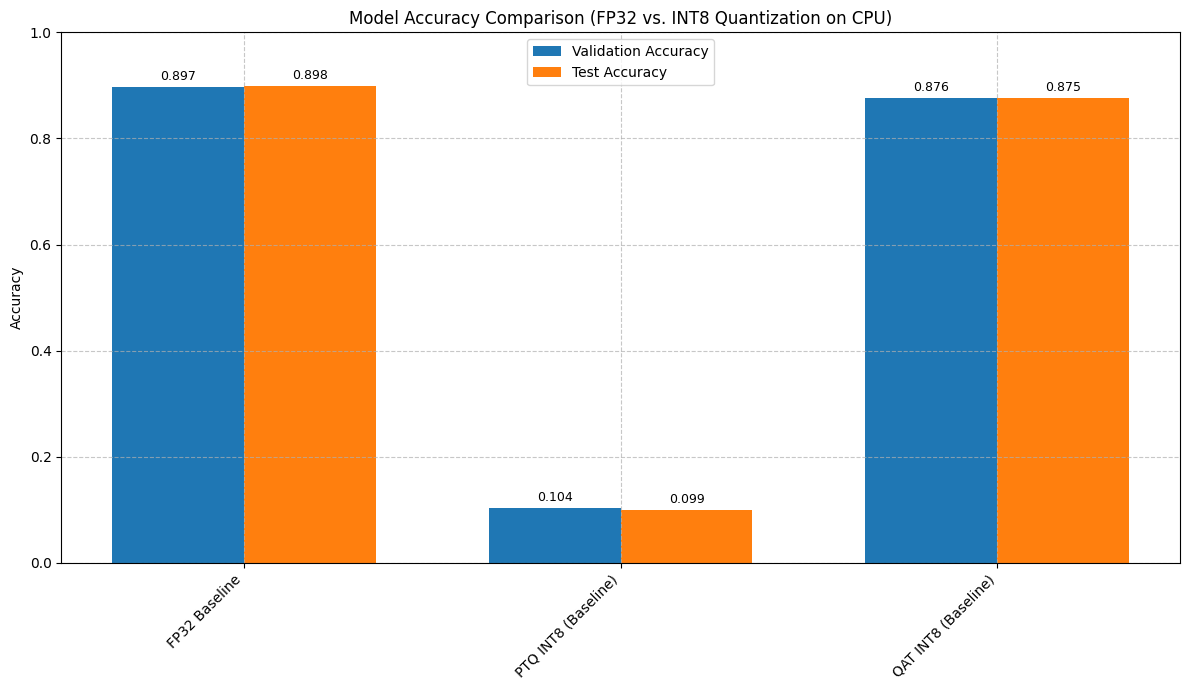

In [28]:
# Accuracy Bar Plot
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, val_accuracies, width, label='Validation Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison (FP32 vs. INT8 Quantization on CPU)')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_ylim(0, 1) # Assuming accuracy is between 0 and 1

def autolabel(rects, ax_to_use):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax_to_use.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1, ax)
autolabel(rects2, ax)

fig.tight_layout()
plt.show()

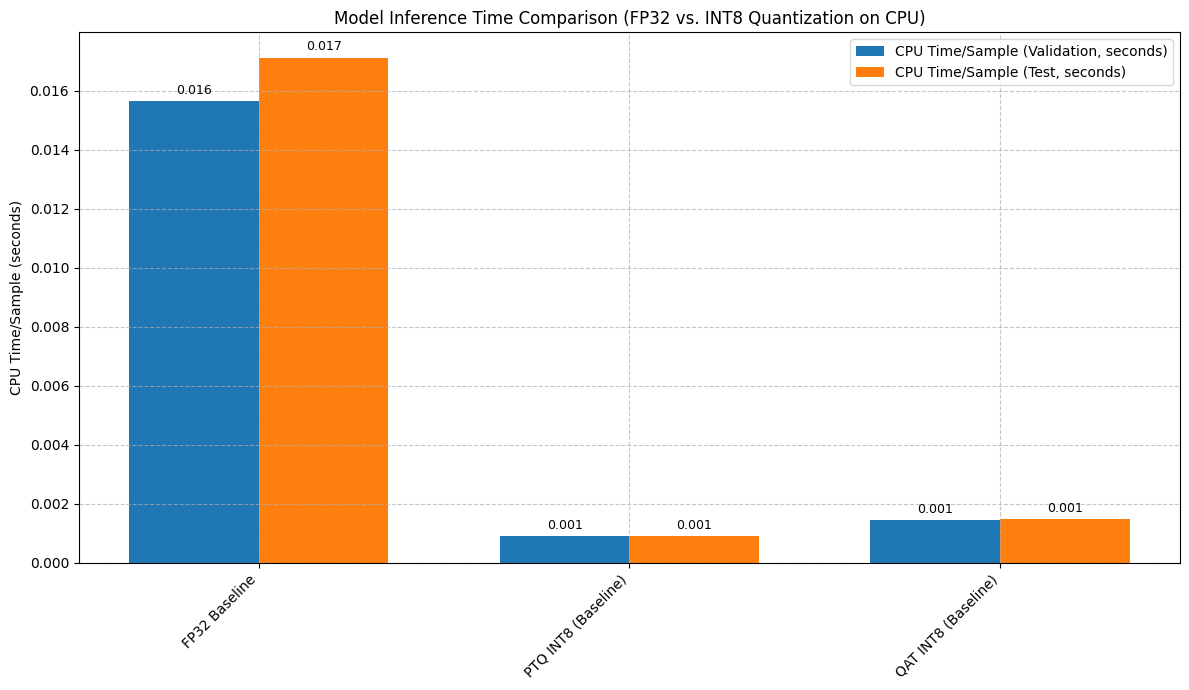

In [29]:
# CPU Inference Time Comparison Plot
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, cpu_time_per_sample_val, width, label='CPU Time/Sample (Validation, seconds)')
rects2 = ax.bar(x + width/2, cpu_time_per_sample_test, width, label='CPU Time/Sample (Test, seconds)')

ax.set_ylabel('CPU Time/Sample (seconds)')
ax.set_title('Model Inference Time Comparison (FP32 vs. INT8 Quantization on CPU)')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

def autolabel(rects, ax_to_use):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax_to_use.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1, ax)
autolabel(rects2, ax)

fig.tight_layout()
plt.show()

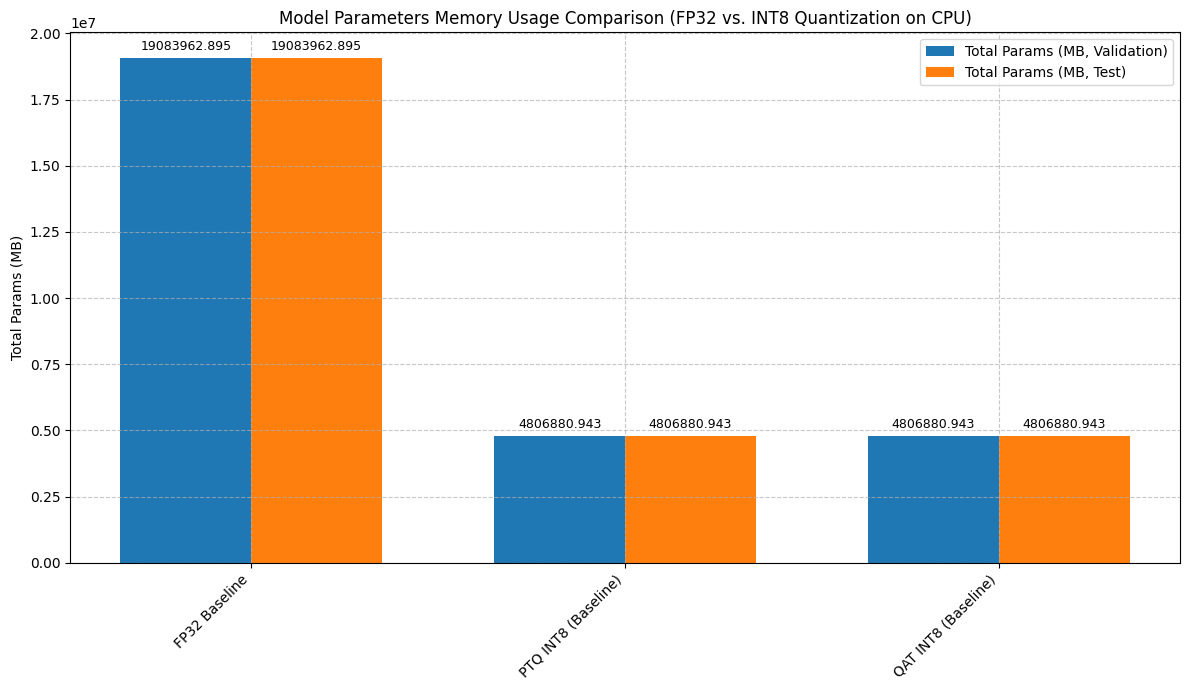

In [30]:
# Total Parameters Memory Usage Plot
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, total_params_mb_val, width, label='Total Params (MB, Validation)')
rects2 = ax.bar(x + width/2, total_params_mb_test, width, label='Total Params (MB, Test)')

ax.set_ylabel('Total Params (MB)')
ax.set_title('Model Parameters Memory Usage Comparison (FP32 vs. INT8 Quantization on CPU)')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

def autolabel(rects, ax_to_use):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax_to_use.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1, ax)
autolabel(rects2, ax)

fig.tight_layout()
plt.show()

## Conclusions

* Not only the quantized model is smaller, but it also has a faster inference time on CPU.
* PTQ is fast and easy to implement, but leads to a catastrophic accuracy drop.
* QAT is more complex (e.g. hard to integrate with pruned models), but it leads to a much smaller accuracy drop compared to PTQ.
* INT8 quantization is thus effective for reducing model size and improving inference speed (on CPU for now), while maintaining acceptable accuracy levels, especially when using QAT.